# Case study of psychological trauma types

The goal of this case study is not just to show you how to read CSV files or construct similarity-based networks. After all, you have been reading about that stuff for almost two hundred pages. You will see that, given the same data, you can transform it into different networks and perhaps even come to different conclusions.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms.bipartite import sets, weighted_projected_graph
from networkx.drawing.nx_agraph import graphviz_layout
import scipy.spatial.distance as dist
from scipy.stats import pearsonr
import community
import generalized
import dzcnapy_plotlib as dzcnapy
import matplotlib.pyplot as plt

Boston’s Justice Resource Institute provided the dataset. You can find it in the file **jri_data.csv**. The file is a correctly formatted CSV table with standard delimiters and a header row at the top. Each of the nineteen columns represents a trauma type.

The trauma names are reasonably self-explanatory, except for PSYC_MALTX (“physical maltreatment”), WAR_NOT_US (“war outside the USA”), and EXT_INTERPER_VIOLENCE (“extended interpersonal violence”).

Each row represents one patient (or subject, as they used to refer to participants in social and behavior studies not so long ago). The original dataset has been already anonymized to preserve the patients’ privacy. The JRI staff replaced each patient’s name with a unique integer number. Since in this study we do not care about the patients’ identity at all, the JRI identifiers have been removed altogether. All we know is that a patient of an unknown age and gender has been exposed to a set of psychological traumas at an unknown time. Respectively, the values of the **DataFrame matrix** are zeros and ones (in the floating-point format), depending on whether the patient in a row was diagnosed with the trauma in a column or not.

In [2]:
matrix = pd.read_csv("jri_data.csv")
print(matrix.columns, matrix.shape)

Index(['SEXUAL_ABUSE', 'SEXUAL_ASSAULT', 'PHYSICAL_ABUSE', 'PHYSICAL_ASSAULT',
       'PSYC_MALTX', 'NEGLECT', 'DOMESTIC_VIOLENCE', 'WAR', 'WAR_NOT_US',
       'MEDICAL_TRAUMA', 'INJURY_ACCIDENT', 'NATURAL_DISASTER', 'KIDNAP',
       'TRAUMTIC_LOSS', 'FORCED_DISPLACEMENT', 'IMPAIRED_CAREGIVER',
       'EXT_INTERPER_VIOLENCE', 'COMMUNITY_VIOLENCE', 'SCHOOL_VIOLENCE'],
      dtype='object') (618, 19)


Let’s build the network of the trauma types four different ways: from Hamming similarity, cosine similarity, Pearson correlation, and generalized similarity. At the moment, you know that each method evaluates similarity in its way and none of the four methods seems to have a clear advantage over the other three. If you randomly commit yourself to one of the methods, you may end up with an inaccurate, distorted, or even incorrect network. You will be able to select the most efficient analysis tool by the end of this chapter.

The first and last networks are induced, so we need a bipartite network **patients_traumas** of patients and trauma types first. We will construct the other two networks directly from the **matrix**. The next code fragment prepares the bipartite network and double checks if it is indeed bipartite. Note that the **matrix** is the bi-adjacency matrix of the network of interest (explainedhere).

In [3]:
# Make a multi-index of patients+traumas
stacked = matrix.stack()
# Select the patients who _have_ traumas
edges = stacked[stacked > 0].index.tolist()
patients_traumas = nx.Graph(edges)
print(nx.is_bipartite(patients_traumas))

True


## Build Four Weighted Networks

Now that you have all the preprocessed data (**DataFrame matrix** and network **patients_traumas**), you can transform it into four weighted networks.

Each column in the **matrix** is a 618-dimensional vector of binary properties of the future trauma node: the property of being diagnosed in patient 0; the property of being diagnosed in patient 1; and so on. Surely, two trauma types are similar if the vectors are similar in some sense. Once the similarities of each pair of vectors are known, the process of network construction is straightforward and can be implemented as a set of functions—at least for the cosine and Pearson distances.

The function **similarity_mtx(biadj_mtx, similarity_f)** takes the bi-adjacency matrix and a similarity measure (a two-argument function that returns the similarity of its parameters) and returns the similarity matrix. The matrix always has ones on the main diagonal because each node is similar to itself. The function removes the main diagonal, which otherwise would result in a bunch of self-loop edges.

In [4]:
def similarity_mtx(biadj_mtx, similarity_f):
    """
    Convert a bi-adjacency matrix to a similarity matrix,
    based on the distance measure
    """
    similarity = [[similarity_f(biadj_mtx[x], biadj_mtx[y])
                   for x in biadj_mtx] for y in biadj_mtx]
    # Discard the main diagonal of ones
    similarity_nodiag = similarity * (1 - np.eye(biadj_mtx.shape[1]))
    similarity_df = pd.DataFrame(similarity_nodiag,
                                 index=biadj_mtx.columns,
                                 columns=biadj_mtx.columns)
    return similarity_df

The function **similarity_net(sim_mtx, threshold=None, density=None)** slices the similarity matrix and converts the surviving entries into the edges of the induced network. Depending on the chosen similarity measure, the interpretation of the edge weight differs. It is not fair to use the same slicing threshold for two similarity matrices computed with different distances and expect them to be comparable. That’s why the function performs slicing based either on the slicing threshold (for the networks that are based on the same distance) or desired network density. Considering that your four networks emerge from four different distance measures, you must use the density-based mechanism. The density of 0.35 seems to produce a nice collection of networks, but you are encouraged to experiment with it.

In [7]:
def similarity_net(sim_mtx, threshold=None, density=None):
    # Convert a similarity to a sliced similarity network
    stacked = sim_mtx.stack()
    if threshold is not None:
        stacked = stacked[stacked >= threshold]
    else:
        count = int(sim_mtx.shape[0] * (sim_mtx.shape[0] - 1) * density)
        stacked = stacked.sort_values(ascending=False)[:count]
    edges = stacked.reset_index()
    edges.columns = "source", "target", "weight"

    network = nx.from_pandas_dataframe(edges, "source", "target",
                                       edge_attr=["weight"])
    # Some nodes may be isolated; they have no incident edges
    network.add_nodes_from(sim_mtx.columns)
    return network

In [8]:
DENSITY = 0.35

Two trauma nodes are cosine similar if the angle between their vectors (_Cosine Distance_) is small and the cosine of the angle is large.

In [9]:
def cosine_sim(x, y):
    return 1 - dist.cosine(x, y)

cosine_mtx = similarity_mtx(matrix, cosine_sim)
cosine_network = similarity_net(cosine_mtx, density=DENSITY)

Two trauma nodes are Pearson similar if their vectors are positively correlated (_Pearson Correlation_). An added benefit of Pearson correlation is that it comes with a p-value. If you want to consider only statistically significant correlations (say, with the p-value<0.01), you can modify the similarity function appropriately.

In [10]:
def pearson_sim(x, y):
    return pearsonr(x, y)[0]

In [12]:
pearson_mtx = similarity_mtx(matrix, pearson_sim)
pearson_network = similarity_net(pearson_mtx, density=DENSITY)


In [13]:
# Shall we discard the statistically insignificant ties?
def pearson_sim_sign(x, y):
    r, pvalue = pearsonr(x, y)
    return r if pvalue < 0.01 else 0

In [14]:
pearson_mtx_sign = similarity_mtx(matrix, pearson_sim_sign)
pearson_network_sign = similarity_net(pearson_mtx_sign, density=DENSITY)


The Hamming and generalized similarity networks are weighted and complete projections of the **patients_traumas** bipartite network. They already contain all edges, and your job is to remove the “weak” edges. The function **slice_projected(net, threshold=None, density=None)** is an equivalent of **similarity_net(sim_mtx, threshold=None, density=None)** and removes the edges that have small weight or make the network too dense.

In [15]:
def slice_projected(net, threshold=None, density=None):
    #    Slice a projected similarity network by threshold or density
    if threshold is not None:
        weak_edges = [(n1, n2) for n1, n2, w in net.edges(data=True)
                      if w["weight"] < threshold]
    else:
        count = int(len(net) * (len(net) - 1) / 2 * density)
        weak_edges = [(n1, n2) for n1, n2, w in
                      sorted(net.edges(data=True),
                             key=lambda x: x[2]["weight"],
                             reverse=True)[count:]]
    net.remove_edges_from(weak_edges)

In [16]:
net1, net2 = sets(patients_traumas)
_, traumas = (net1, net2) if "WAR" in net2 else (net2, net1)
hamming_network = weighted_projected_graph(patients_traumas,
                                           traumas, ratio=True)
slice_projected(hamming_network, density=DENSITY)

Two trauma nodes are generally similar if the trauma types have frequently been observed in similar patients (_Generalized Similarity_). This piece of code incidentally also generates a similarity network of the patients, which you do not need for this project.

In [17]:
net1, net2, eps, n = generalized.generalized_similarity(patients_traumas)
_, generalized_network = (net1, net2) if "WAR" in net2 else (net2, net1)
slice_projected(generalized_network, density=DENSITY)
generalized_network.remove_edges_from(generalized_network.selfloop_edges())

## Plot and Compare the Networks
All four networks have the same number of nodes and similar density (and a similar number of edges), which makes them very easy to compare. The following picture shows the charts of all four networks.

In [52]:
networks = {
    "generalized" : generalized_network,
    "pearson" : pearson_network_sign,
    "cosine" : cosine_network,
    "hamming" : hamming_network,
    }

partitions = [community.best_partition(x) for x in networks.values()]
statistics = sorted([
        (name,
         community.modularity(best_part, netw),
         len(set(best_part.values())),
         len(list(nx.isolates(netw)))
         ) for (name, netw), best_part in zip(networks.items(), partitions)],
                    key=lambda x: x[1], reverse=True)
print(statistics)

[('generalized', 0.4727815586231902, 4, 0), ('pearson', 0.20116056253791004, 4, 0), ('cosine', 0.03554158315213061, 6, 4), ('hamming', -3.3306690738754696e-16, 7, 6)]


In [51]:
for (name, netw), best_part in zip(networks.items(), partitions): 
    print(name,community.modularity(best_part,netw),len(set(best_part.values())),len(list(nx.isolates(netw))))

generalized 0.4727815586231902 4 0
pearson 0.20116056253791004 4 0
cosine 0.03554158315213061 6 4
hamming -3.3306690738754696e-16 7 6


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Liberation Sans Narrow'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


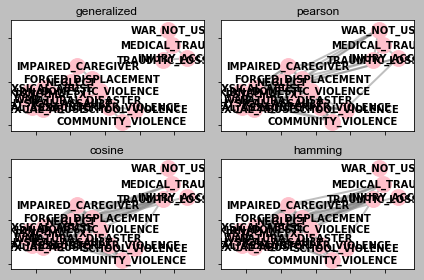

In [54]:
pos = graphviz_layout(generalized_network)

for i, (name, _, _, _) in enumerate(statistics):
    net = networks[name]
    ax = plt.subplot(2, 2, i + 1)
    nx.draw_networkx_edges(net, pos, ax=ax, alpha=0.5, **dzcnapy.medium_attrs)
    nx.draw_networkx_nodes(net, pos, ax=ax, **dzcnapy.medium_attrs)
    nx.draw_networkx_labels(net, pos, ax=ax, **dzcnapy.medium_attrs)
    dzcnapy.set_extent(pos, ax, name)

dzcnapy.plot("compare_traumas")

As usual, visualizations are likely to be much better if you save your graphs and open them with **Gephi** (do it on your own).

**Observation:** The generalized similarity network has no isolated nodes, the highest modularity, and the smallest number of detected communities. Its community structure partitions the trauma types into the smallest number of well-defined groups of similar size. These groups are compact and homogeneous, and with some effort (and with some help from a field expert) can be labeled, as shown in the following table.

In [71]:
tag_clusters = pd.DataFrame({"part_id" : pd.Series(community.best_partition(generalized_network))})
results = tag_clusters.groupby("part_id")
for r in results:
  print(r)

(0,                  part_id
INJURY_ACCIDENT        0
MEDICAL_TRAUMA         0
TRAUMTIC_LOSS          0
WAR_NOT_US             0)
(1,                   part_id
KIDNAP                  1
PHYSICAL_ABUSE          1
PHYSICAL_ASSAULT        1
PSYC_MALTX              1
SEXUAL_ABUSE            1
SEXUAL_ASSAULT          1
WAR                     1)
(2,                        part_id
COMMUNITY_VIOLENCE           2
EXT_INTERPER_VIOLENCE        2
SCHOOL_VIOLENCE              2)
(3,                      part_id
DOMESTIC_VIOLENCE          3
FORCED_DISPLACEMENT        3
IMPAIRED_CAREGIVER         3
NATURAL_DISASTER           3
NEGLECT                    3)
